In [1]:
from GoodVibrations import get_melspectrogram_db, spec_to_image, Audio, audio2image, train

from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.models import resnet34
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import numpy as np

%matplotlib inline

# Part 1: Organizing and Preparing Data
We will represent audio wav files as 2-dim spectrograms. That way, we can piggyback off pretrained computer vision models such as Resnet.

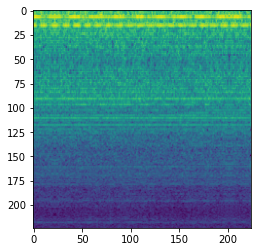

In [2]:
fnames = glob("train_data/*")
labels = list(map(lambda x: int(x.split("-")[1].split('.')[0]), fnames))

x = audio2image(fnames[0])
plt.imshow(x)

Text(0.5, 1.0, 'Data Distribution')

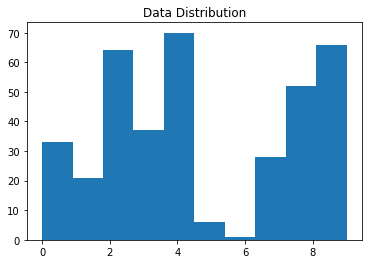

In [3]:
plt.hist(labels)[2]
plt.title("Data Distribution")

We will split 80 train/20 validation for model training..

In [8]:
data = Audio(fnames, transform=transforms.ToTensor())

train_size = int(len(data) * .80)  # use 80/20 split
val_size = len(data) - train_size

train_set, val_set = random_split(data, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=12, shuffle=True)
val_loader = DataLoader(val_set, batch_size=12, shuffle=True)

100%|██████████| 290/290 [00:17<00:00, 16.82it/s]


# Part 2: Prepare Model
We will use a pretrained Resnet34 model. 

There are a few modifications we need to make: (a) changing the number of classes from 1000 to 10 (since we have ten classes) and (b) changing input channels from three (imagenet images are rgb images) to one (since a spectrogram is a 2d image with one channel).

In [9]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [10]:
n_classes = 10
n_input_channel = 1

In [11]:
model = resnet34(pretrained=True)
model.fc = nn.Linear(512, n_classes)
model.conv1 = nn.Conv2d(n_input_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

In [12]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Part 3: Training
Fitting a pretrained Resnet34 model on spectrograms gives us ~95% accuracy on audio data.

In [14]:
n_epochs = 1

train(model, loss_fn, train_loader, val_loader, n_epochs, optimizer)

using pretrained model


  0%|          | 0/1 [00:00<?, ?it/s]

epoch - 0 Train-Loss : 0.12627847734838724


100%|██████████| 1/1 [01:38<00:00, 98.44s/it]

epoch - 0 Val-Loss : 0.0656891867518425 Val-Accuracy : 0.9827586206896551


# Part 4: Inference

In [16]:
# prepare test data
fnames = glob("test_data/*")
data = Audio(fnames, transform=transforms.ToTensor())
test_loader = DataLoader(data, batch_size=1)

# inference
for fname, pair in zip(fnames, test_loader):
    x, _ = pair
    x = x.to(device, dtype=torch.float32)
    pred = model(x)
    print("predictions:", fname, pred.argmax(axis=1))

100%|██████████| 11/11 [00:00<00:00, 17.37it/s]


predictions: test_data/4011-7.wav tensor([7])
predictions: test_data/4008-7.wav tensor([7])
predictions: test_data/4115-2.wav tensor([2])
predictions: test_data/4131-3.wav tensor([3])
predictions: test_data/4010-7.wav tensor([7])
predictions: test_data/4009-7.wav tensor([7])
predictions: test_data/4086-0.wav tensor([0])
predictions: test_data/4007-7.wav tensor([7])
predictions: test_data/4098-0.wav tensor([0])
predictions: test_data/4006-7.wav tensor([7])
predictions: test_data/4139-3.wav tensor([3])
